In [1]:
# Install required packages
!pip install torchinfo

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from IPython.display import clear_output
import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration (use T4 GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
def load_and_preprocess_data(pv_file='pv_power.csv', weather_file='weather.csv', seq_length=24):
    """Load and preprocess solar power and weather data with per-feature normalization."""
    # Load CSV files
    pv_data = pd.read_csv(pv_file)
    weather_data = pd.read_csv(weather_file)

    # Rename columns for consistency
    pv_data = pv_data.rename(columns={'DATE_TIME': 'timestamp', 'AC_POWER': 'power',
                                      'DC_POWER': 'dc_power', 'DAILY_YIELD': 'daily_yield',
                                      'TOTAL_YIELD': 'total_yield'})
    weather_data = weather_data.rename(columns={'DATE_TIME': 'timestamp', 'AMBIENT_TEMPERATURE': 'temp',
                                                'IRRADIATION': 'irradiation', 'MODULE_TEMPERATURE': 'module_temp'})

    # Convert timestamp to datetime
    pv_data['timestamp'] = pd.to_datetime(pv_data['timestamp'])
    weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'])

    # Merge on timestamp
    data = pd.merge(pv_data[['timestamp', 'power', 'dc_power', 'daily_yield', 'total_yield']],
                    weather_data[['timestamp', 'temp', 'irradiation', 'module_temp']],
                    on='timestamp', how='inner')

    if data.empty:
        raise ValueError("Merge resulted in empty DataFrame. Check timestamp overlap in CSV files.")

    # Resample to hourly
    data = data.set_index('timestamp').resample('1H').mean().interpolate(method='linear').reset_index()

    # Handle missing values
    data = data.dropna()

    # Add temporal and derived features
    data['hour'] = data['timestamp'].dt.hour
    data['temp_diff'] = data['module_temp'] - data['temp']
    data['yield_rate'] = data['daily_yield'] / (data['irradiation'] + 1e-10)  # Avoid division by zero

    # Feature selection
    features = ['temp', 'irradiation', 'module_temp', 'dc_power', 'power', 'daily_yield', 'total_yield',
                'hour', 'temp_diff', 'yield_rate']
    data = data[features]

    # Normalize each feature independently
    scalers = {}
    scaled_data = np.zeros_like(data.values)
    for i, feature in enumerate(features):
        scalers[feature] = MinMaxScaler()
        scaled_data[:, i] = scalers[feature].fit_transform(data[[feature]].values).flatten()

    # Create sequences with augmentation
    X, y = [], []
    for i in range(len(scaled_data) - seq_length):
        seq = scaled_data[i:i + seq_length].copy()
        # Add small noise for robustness (only during training)
        if i < int(0.6 * (len(scaled_data) - seq_length)):  # Train set only
            noise = np.random.normal(0, 0.01, seq.shape)
            seq += noise
            seq = np.clip(seq, 0, 1)  # Keep within [0, 1]
        X.append(seq)
        y.append(scaled_data[i + seq_length, features.index('power')])  # Target is next hour's power

    X = np.array(X)
    y = np.array(y)

    # Split data (60% train, 20% val, 20% test)
    train_size = int(0.6 * len(X))
    val_size = int(0.20 * len(X))
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

    # Create DataLoaders
    batch_size = 32
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, scalers, len(features)

In [3]:
# Load data (assumes pv_power.csv and weather.csv are uploaded)
train_loader, val_loader, test_loader, scaler, num_features = load_and_preprocess_data()
print(f"Number of features: {num_features}")

Number of features: 10


<ipython-input-2-6a4047475b55>:15: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pv_data['timestamp'] = pd.to_datetime(pv_data['timestamp'])
<ipython-input-2-6a4047475b55>:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.set_index('timestamp').resample('1H').mean().interpolate(method='linear').reset_index()


In [4]:
class CPOBiGRUAttention(nn.Module):
    """Hybrid BiGRU-MultiHeadAttention model for PV power forecasting."""
    def __init__(self, num_features, gru_units, num_heads, dropout_rate):
        super(CPOBiGRUAttention, self).__init__()
        self.bigru = nn.GRU(num_features, gru_units, num_layers=2, bidirectional=True, batch_first=True)
        self.ln = nn.LayerNorm(gru_units * 2)
        self.attention = nn.MultiheadAttention(embed_dim=gru_units * 2, num_heads=num_heads, batch_first=True)
        self.fc1 = nn.Linear(gru_units * 2, gru_units)
        self.fc2 = nn.Linear(gru_units, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.bigru(x)  # (batch_size, seq_length, 2 * gru_units)
        x = self.ln(x)
        attn_output, _ = self.attention(x, x, x)
        x = attn_output[:, -1, :]  # (batch_size, 2 * gru_units)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)  # (batch_size, 1)
        return x

# Test model instantiation
test_model = CPOBiGRUAttention(num_features=3, gru_units=32, num_heads=2, dropout_rate=0.2)
print("Model instantiated successfully:", test_model)

Model instantiated successfully: CPOBiGRUAttention(
  (bigru): GRU(3, 32, num_layers=2, batch_first=True, bidirectional=True)
  (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


Best parameters found:
GRU Units: 224
Number of Attention Heads: 2
Dropout Rate: 0.1431
Learning Rate: 0.000221
Best Validation Loss: 0.005637


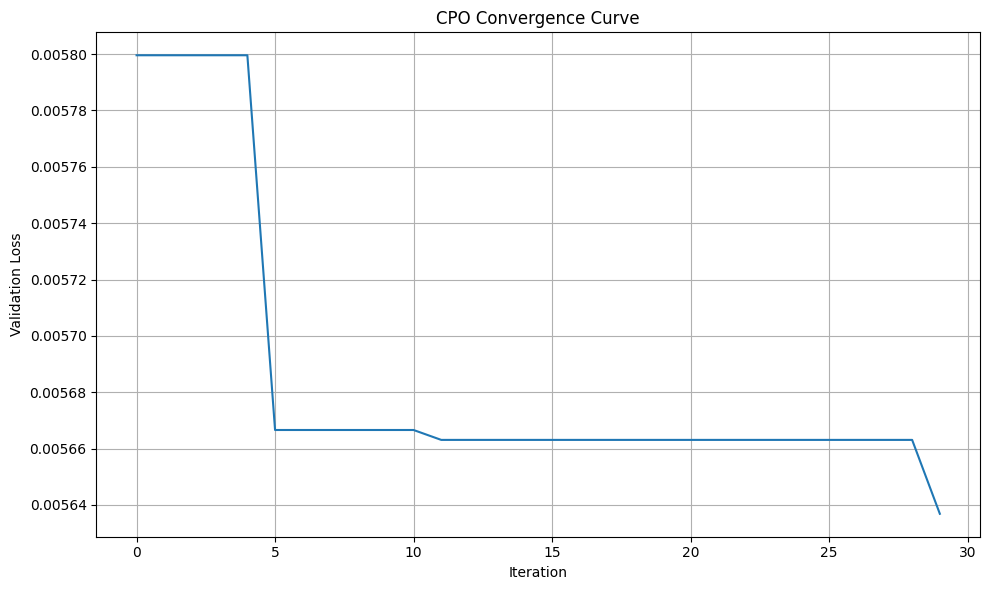

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
import pandas as pd
import os
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class CPOBiGRUAttention(nn.Module):
    """Hybrid BiGRU-MultiHeadAttention model for PV power forecasting."""
    def __init__(self, num_features, gru_units, num_heads, dropout_rate):
        super(CPOBiGRUAttention, self).__init__()
        self.bigru = nn.GRU(num_features, gru_units, num_layers=2, bidirectional=True, batch_first=True)
        self.ln = nn.LayerNorm(gru_units * 2)
        self.attention = nn.MultiheadAttention(embed_dim=gru_units * 2, num_heads=num_heads, batch_first=True)
        self.fc1 = nn.Linear(gru_units * 2, gru_units)
        self.fc2 = nn.Linear(gru_units, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.bigru(x)  # (batch_size, seq_length, 2 * gru_units)
        x = self.ln(x)
        attn_output, _ = self.attention(x, x, x)
        x = attn_output[:, -1, :]  # (batch_size, 2 * gru_units)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)  # (batch_size, 1)
        return x

def initialization(SearchAgents_no, dim, ub, lb):
    """Initialize positions with improved distribution across parameter space"""
    Positions = np.zeros((SearchAgents_no, dim))

    # Use Latin Hypercube Sampling for better coverage of search space
    for i in range(dim):
        # Create evenly spaced segments
        segments = np.linspace(0, 1, SearchAgents_no + 1)
        points = np.random.uniform(segments[:-1], segments[1:])
        np.random.shuffle(points)  # Shuffle to avoid correlation
        # Scale to parameter range
        Positions[:, i] = lb[i] + points * (ub[i] - lb[i])

    # Ensure GRU units are integers
    Positions[:, 0] = np.round(Positions[:, 0])

    # Adjust num_heads for compatibility with GRU units
    for i in range(SearchAgents_no):
        Positions[i, 1] = adjust_gru_heads(Positions[i, 0], Positions[i, 1], lb[1], ub[1])

    return Positions

def adjust_gru_heads(gru_units, num_heads, lb_heads, ub_heads):
    """Find valid number of attention heads for given GRU units"""
    gru_units = int(round(gru_units))
    embed_dim = 2 * gru_units  # Bidirectional GRU output dimension

    # Find all valid heads within bounds
    valid_heads = [h for h in range(int(lb_heads), int(ub_heads) + 1)
                  if h > 0 and embed_dim % h == 0]

    # If no valid heads found, adjust gru_units slightly to find valid combinations
    if not valid_heads:
        # Try neighboring GRU unit values
        for offset in range(1, 10):
            for direction in [1, -1]:
                new_gru = gru_units + direction * offset
                new_embed_dim = 2 * new_gru

                # Check if this creates valid head options
                for h in range(int(lb_heads), int(ub_heads) + 1):
                    if h > 0 and new_embed_dim % h == 0:
                        return h

        # Fallback to a safe value
        return max(int(lb_heads), 2)

    # Choose head value closest to the requested value
    return valid_heads[np.argmin(np.abs(np.array(valid_heads) - num_heads))]

def CPO(Pop_size, Tmax, lb, ub, dim, fobj):
    """Improved Crested Porcupine Optimization with adaptive parameters"""
    Conv_curve = np.zeros(Tmax)
    ub = np.array(ub)
    lb = np.array(lb)

    # Initialize population
    X = initialization(Pop_size, dim, ub, lb)

    # Initialize best solution tracking
    best_sols = []  # Track best solutions over time
    stall_counter = 0
    last_best_fit = float('inf')

    # Evaluate initial fitness (with more robust evaluation)
    fitness = np.array([fobj_with_retry(X[i, :]) for i in range(Pop_size)])
    fitness = np.nan_to_num(fitness, nan=np.inf)

    # Track global best
    Gb_idx = np.argmin(fitness)
    Gb_Fit = fitness[Gb_idx]
    Gb_Sol = X[Gb_idx, :].copy()
    best_sols.append(Gb_Sol.copy())

    # Initialize memory for previous positions
    Xp = X.copy()

    with tqdm(total=Tmax, desc='CPO Optimization', unit='iter') as pbar:
        for t in range(Tmax):
            # Dynamic parameter adjustment based on iteration
            progress = t / Tmax

            # Adaptive scales - decrease over time but maintain minimum exploration
            global_scale = 0.2 * (1 - progress)**0.5 + 0.05
            local_scale = 0.15 * (1 - progress)**0.3 + 0.02

            # Adaptive exploration probability - higher early, lower later
            exploration_prob = 0.7 * (1 - progress)**0.7 + 0.2

            # Sort by fitness for rank-based selection
            sorted_idx = np.argsort(fitness)

            for i in range(Pop_size):
                # Different strategies based on agent rank
                agent_rank = np.where(sorted_idx == i)[0][0] / Pop_size

                # Generate random binary mask
                U1 = np.random.rand(dim) > 0.5  # Balanced mask

                # Custom scales for different parameters
                scale = np.array([0.2, 0.15, 0.1, 0.1])

                if np.random.rand() < exploration_prob:  # Exploration phase
                    if agent_rank < 0.3 or np.random.rand() < 0.7:  # Elite agents or random chance
                        # Move toward global best with noise
                        rand_agent = X[np.random.randint(Pop_size), :]
                        y = (X[i, :] + rand_agent) / 2
                        noise = np.random.randn(dim) * scale * global_scale
                        X_new = X[i, :] + noise * abs(2 * np.random.rand() * Gb_Sol - y)
                    else:
                        # Strong exploration for weaker solutions
                        y1 = X[np.random.choice(sorted_idx[:5])].copy()  # Top 5 solution
                        y2 = X[np.random.randint(Pop_size), :].copy()    # Random solution
                        blend = np.random.rand()
                        X_new = U1 * X[i, :] + (1-U1) * (blend * y1 + (1-blend) * y2 +
                                                          global_scale * np.random.randn(dim) * (ub - lb) * scale)
                else:  # Exploitation phase
                    # Adaptive exploitation factor
                    Yt = 2 * (np.random.rand() * 0.5 + 0.5) * (1 - progress)**2
                    U2 = (np.random.rand(dim) < 0.5) * 2 - 1  # Random direction

                    if agent_rank < 0.5 or np.random.rand() < 0.6:  # Better solutions
                        # Fitness-weighted movement toward top solutions
                        fit_weight = np.exp(-fitness[i] / (np.mean(fitness) + np.finfo(float).eps))

                        # Select from top solutions with preference to best
                        top_k = max(3, int(5 * (1-progress)))  # Adaptive number of top solutions
                        top_probs = np.exp(-np.arange(top_k) / 2)
                        top_probs = top_probs / np.sum(top_probs)
                        leader_idx = np.random.choice(sorted_idx[:top_k], p=top_probs)
                        leader = X[leader_idx, :].copy()

                        # Adaptive step size based on fitness and progress
                        step = fit_weight * local_scale * (1 + np.random.rand())
                        X_new = X[i, :] + step * U2 * (leader - X[i, :])

                        # Add small perturbation for diversity
                        X_new += 0.05 * local_scale * np.random.randn(dim) * (ub - lb) * scale
                    else:
                        # More aggressive movement for worse solutions
                        top_idx = sorted_idx[:3]  # Top 3 solutions
                        leader = X[np.random.choice(top_idx), :].copy()

                        # Calculate direction based on differences between solutions
                        diff_vector = leader - X[i, :]
                        step_size = Yt * (0.5 + np.random.rand() * 0.5)
                        X_new = X[i, :] + step_size * diff_vector + local_scale * np.random.randn(dim) * scale * (ub - lb)

                # Make sure gru_units is an integer
                X_new[0] = round(X_new[0])

                # Ensure num_heads is compatible with gru_units
                X_new[1] = adjust_gru_heads(X_new[0], X_new[1], lb[1], ub[1])

                # Ensure within bounds
                X_new = np.clip(X_new, lb, ub)

                # Evaluate new fitness (with optimized evaluation strategy)
                nF = fobj_with_retry(X_new)
                nF = np.nan_to_num(nF, nan=np.inf)

                # Update position if better
                if nF < fitness[i]:
                    Xp[i, :] = X[i, :].copy()  # Backup current
                    X[i, :] = X_new.copy()
                    fitness[i] = nF

                    # Update global best if needed
                    if nF < Gb_Fit:
                        Gb_Sol = X_new.copy()
                        Gb_Fit = nF
                        best_sols.append(Gb_Sol.copy())

                        # Reset stall counter on improvement
                        stall_counter = 0

                        # Log significant improvement
                        if Gb_Fit < last_best_fit * 0.95:  # 5% improvement
                            pbar.write(f"Significant improvement: {Gb_Fit:.5f}, Parameters: gru={int(Gb_Sol[0])}, "
                                      f"heads={int(Gb_Sol[1])}, dropout={Gb_Sol[2]:.2f}, lr={np.exp(Gb_Sol[3]):.6f}")

            # Diversity maintenance and stagnation handling
            improvement = abs((Gb_Fit - last_best_fit) / (last_best_fit + 1e-10))
            if improvement < 0.01:  # Less than 1% improvement
                stall_counter += 1
            else:
                stall_counter = max(0, stall_counter - 1)  # Reduce counter on improvement

            last_best_fit = Gb_Fit

            # Handle stagnation with increasing aggressiveness
            if stall_counter >= 3:
                # Perturb increasing percentage of population
                perturb_ratio = min(0.1 + 0.1 * (stall_counter - 3), 0.5)  # Up to 50%
                num_perturb = int(perturb_ratio * Pop_size)

                # Target weaker solutions preferentially
                perturb_candidates = sorted_idx[Pop_size//3:]  # Skip top third
                if len(perturb_candidates) > num_perturb:
                    perturb_idx = np.random.choice(perturb_candidates, num_perturb, replace=False)
                else:
                    perturb_idx = perturb_candidates

                for idx in perturb_idx:
                    # Progressive perturbation strength
                    perturb_strength = 0.05 * (1 + stall_counter / 3)

                    # Different perturbation strategies
                    if np.random.rand() < 0.7:
                        # Perturb around current position
                        X[idx, :] += np.random.randn(dim) * (ub - lb) * perturb_strength * scale
                    else:
                        # Hard reset with bias toward promising regions
                        if len(best_sols) > 3 and np.random.rand() < 0.5:
                            # Initialize around previous best solutions
                            base_sol = best_sols[np.random.randint(len(best_sols))]
                            X[idx, :] = base_sol + np.random.randn(dim) * (ub - lb) * 0.2 * scale
                        else:
                            # Fresh random initialization
                            for d in range(dim):
                                X[idx, d] = np.random.uniform(lb[d], ub[d])

                    # Fix gru_units and num_heads
                    X[idx, 0] = round(X[idx, 0])
                    X[idx, 1] = adjust_gru_heads(X[idx, 0], X[idx, 1], lb[1], ub[1])
                    X[idx, :] = np.clip(X[idx, :], lb, ub)

                    # Re-evaluate fitness
                    fitness[idx] = fobj_with_retry(X[idx, :])
                    fitness[idx] = np.nan_to_num(fitness[idx], nan=np.inf)

                    # Update global best if better
                    if fitness[idx] < Gb_Fit:
                        Gb_Sol = X[idx, :].copy()
                        Gb_Fit = fitness[idx]
                        best_sols.append(Gb_Sol.copy())

                # Reset stall counter if we've done a major perturbation
                if perturb_ratio > 0.2:
                    stall_counter = 0

            # Update convergence curve and progress bar
            Conv_curve[t] = Gb_Fit
            pbar.set_postfix({'Best Fitness': Gb_Fit,
                              'gru': int(Gb_Sol[0]),
                              'heads': int(Gb_Sol[1]),
                              'dropout': f"{Gb_Sol[2]:.2f}",
                              'lr': f"{np.exp(Gb_Sol[3]):.6f}"})
            pbar.update(1)

            # Early stopping if excellent solution found and stabilized
            if Gb_Fit < 0.001 and stall_counter >= 5:
                pbar.write(f"Early stopping at iteration {t+1}: solution converged")
                Conv_curve[t+1:] = Gb_Fit
                break

    return Gb_Fit, Gb_Sol, Conv_curve

def fobj_with_retry(params, max_retries=2):
    """Robust objective function evaluation with retries and cross-validation"""
    best_of_n = 3  # Take best of N evaluations for more stability
    results = []

    for _ in range(best_of_n):
        for attempt in range(max_retries + 1):
            try:
                val = fobj(params)
                if not np.isnan(val) and not np.isinf(val):
                    results.append(val)
                    break
            except Exception as e:
                if attempt == max_retries:
                    print(f"Failed evaluation after {max_retries} retries: {e}")
                    return np.inf

    if not results:
        return np.inf

    # Return median of results for robustness (less sensitive to outliers than mean)
    return np.median(results)

def fobj(params):
    """Objective function for neural network hyperparameter optimization"""
    if np.any(np.isnan(params)):
        return np.inf

    # Round GRU units to integer
    gru_units = int(round(params[0]))
    num_heads = int(round(params[1]))
    dropout_rate = params[2]
    learning_rate = np.exp(params[3])  # Convert from log scale

    # Verify head compatibility
    if (2 * gru_units) % num_heads != 0:
        return np.inf

    # Prevent extremes that might lead to unstable training
    if gru_units < 64 or gru_units > 512:
        return np.inf
    if num_heads < 1 or dropout_rate < 0.1 or dropout_rate > 0.5:
        return np.inf

    # Create and train the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CPOBiGRUAttention(num_features, gru_units, num_heads, dropout_rate).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    num_epochs = 60
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()
        val_loss /= len(val_loader)

        # Learning rate adjustment
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_loss

# Load data
try:
    train_loader, val_loader, test_loader, scalers, num_features = load_and_preprocess_data()
    print(f"Number of features: {num_features}")
except Exception as e:
    print(f"Error loading data: {e}")
    # Simulate data for testing if needed
    num_features = 3  # Placeholder
    raise ValueError("Data loading failed; check pv_power.csv and weather.csv.")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Run CPO optimization with improved parameters
Pop_size = 15  # Population size
Tmax = 30      # Increased max iterations
dim = 4        # Number of parameters to optimize

# Parameter bounds (wider range for better exploration)
lb = [64, 2, 0.1, np.log(0.0001)]  # Log-scale learning rate
ub = [320, 16, 0.5, np.log(0.01)]   # Upper bound increased

print("Starting CPO optimization...")
best_fit, best_sol, conv_curve = CPO(Pop_size, Tmax, lb, ub, dim, fobj)
clear_output(wait=True)

# Handle any NaN results
if np.any(np.isnan(best_sol)):
    print("Warning: CPO returned NaN values. Using default parameters.")
    best_sol = [128, 4, 0.3, np.log(0.001)]  # Default fallback

# Convert parameters to appropriate types
best_gru_units = int(round(best_sol[0]))
best_num_heads = int(round(best_sol[1]))
best_dropout = best_sol[2]
best_lr = np.exp(best_sol[3])  # Convert from log scale

print(f"Best parameters found:")
print(f"GRU Units: {best_gru_units}")
print(f"Number of Attention Heads: {best_num_heads}")
print(f"Dropout Rate: {best_dropout:.4f}")
print(f"Learning Rate: {best_lr:.6f}")
print(f"Best Validation Loss: {best_fit:.6f}")

# Plot convergence curve
plt.figure(figsize=(10, 6))
plt.plot(conv_curve)
plt.title('CPO Convergence Curve')
plt.xlabel('Iteration')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.savefig('cpo_convergence.png')
plt.show()



In [12]:
model = CPOBiGRUAttention(
    num_features, int(best_sol[0]), int(best_sol[1]), best_sol[2]
).to(device)
optimizer = optim.Adam(model.parameters(), lr=np.exp(best_sol[3]))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.MSELoss()

num_epochs = 110
patience = 10
best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            val_loss += criterion(outputs, y_batch).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/110: 100%|██████████| 15/15 [00:00<00:00, 92.94it/s]


Epoch 1/110, Train Loss: 0.1119, Val Loss: 0.0525


Epoch 2/110: 100%|██████████| 15/15 [00:00<00:00, 108.05it/s]


Epoch 2/110, Train Loss: 0.0432, Val Loss: 0.0184


Epoch 3/110: 100%|██████████| 15/15 [00:00<00:00, 126.61it/s]


Epoch 3/110, Train Loss: 0.0164, Val Loss: 0.0075


Epoch 4/110: 100%|██████████| 15/15 [00:00<00:00, 122.71it/s]


Epoch 4/110, Train Loss: 0.0119, Val Loss: 0.0083


Epoch 5/110: 100%|██████████| 15/15 [00:00<00:00, 118.90it/s]


Epoch 5/110, Train Loss: 0.0100, Val Loss: 0.0062


Epoch 6/110: 100%|██████████| 15/15 [00:00<00:00, 122.02it/s]


Epoch 6/110, Train Loss: 0.0139, Val Loss: 0.0078


Epoch 7/110: 100%|██████████| 15/15 [00:00<00:00, 122.50it/s]


Epoch 7/110, Train Loss: 0.0119, Val Loss: 0.0073


Epoch 8/110: 100%|██████████| 15/15 [00:00<00:00, 115.01it/s]


Epoch 8/110, Train Loss: 0.0120, Val Loss: 0.0064


Epoch 9/110: 100%|██████████| 15/15 [00:00<00:00, 84.38it/s]


Epoch 9/110, Train Loss: 0.0099, Val Loss: 0.0074


Epoch 10/110: 100%|██████████| 15/15 [00:00<00:00, 86.67it/s]


Epoch 10/110, Train Loss: 0.0103, Val Loss: 0.0066


Epoch 11/110: 100%|██████████| 15/15 [00:00<00:00, 89.89it/s]


Epoch 11/110, Train Loss: 0.0108, Val Loss: 0.0059


Epoch 12/110: 100%|██████████| 15/15 [00:00<00:00, 91.76it/s]


Epoch 12/110, Train Loss: 0.0075, Val Loss: 0.0071


Epoch 13/110: 100%|██████████| 15/15 [00:00<00:00, 92.21it/s]


Epoch 13/110, Train Loss: 0.0090, Val Loss: 0.0070


Epoch 14/110: 100%|██████████| 15/15 [00:00<00:00, 92.71it/s]


Epoch 14/110, Train Loss: 0.0098, Val Loss: 0.0085


Epoch 15/110: 100%|██████████| 15/15 [00:00<00:00, 89.22it/s]


Epoch 15/110, Train Loss: 0.0083, Val Loss: 0.0080


Epoch 16/110: 100%|██████████| 15/15 [00:00<00:00, 85.05it/s]


Epoch 16/110, Train Loss: 0.0082, Val Loss: 0.0092


Epoch 17/110: 100%|██████████| 15/15 [00:00<00:00, 85.92it/s]


Epoch 17/110, Train Loss: 0.0095, Val Loss: 0.0079


Epoch 18/110: 100%|██████████| 15/15 [00:00<00:00, 82.89it/s]


Epoch 18/110, Train Loss: 0.0101, Val Loss: 0.0071


Epoch 19/110: 100%|██████████| 15/15 [00:00<00:00, 100.41it/s]


Epoch 19/110, Train Loss: 0.0099, Val Loss: 0.0079


Epoch 20/110: 100%|██████████| 15/15 [00:00<00:00, 110.98it/s]


Epoch 20/110, Train Loss: 0.0096, Val Loss: 0.0065


Epoch 21/110: 100%|██████████| 15/15 [00:00<00:00, 121.12it/s]

Early stopping triggered at epoch 21.


CPO+BiGRU+Attention Test RMSE: 89.2064, MAE: 54.1565, MAPE: 30.32%, R²: 0.9363


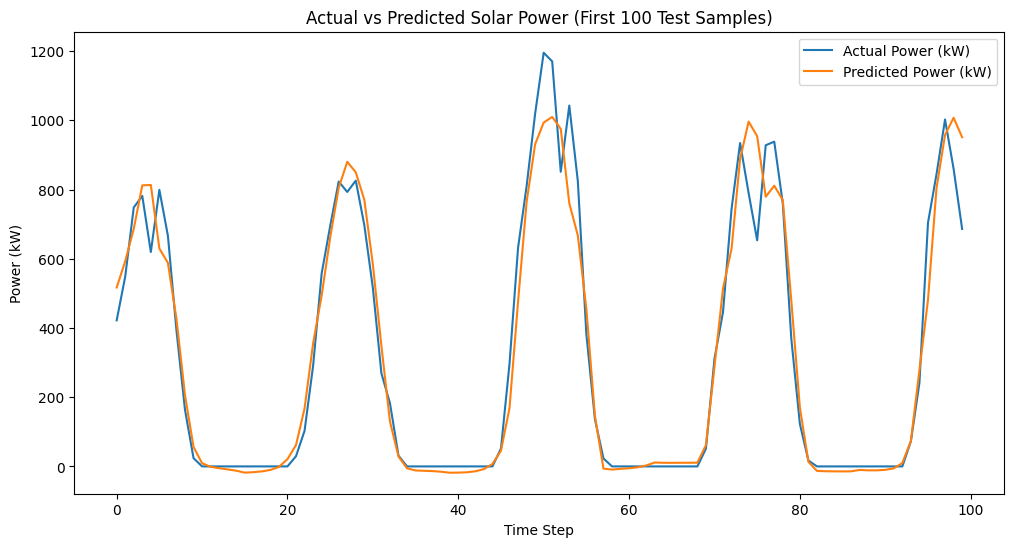

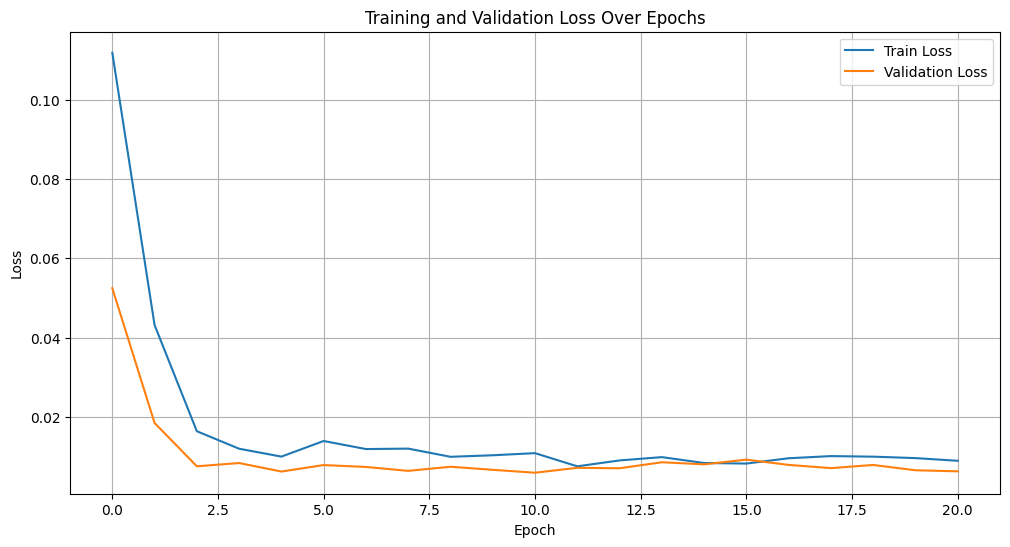

Results saved in results_cpo_bigru_20250417_115537/


In [13]:
try:
    scalers
except NameError:
    train_loader, val_loader, test_loader, scalers, num_features = load_and_preprocess_data()
    print("Reloaded data to retrieve scalers.")

model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)
predictions = scalers['power'].inverse_transform(predictions)
actuals = scalers['power'].inverse_transform(actuals)

# Compute metrics
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
valid_mask = actuals.flatten() > 1e-5
mape = np.mean(np.abs((actuals[valid_mask] - predictions[valid_mask]) /
                      (actuals[valid_mask] + 1e-10))) * 100 if valid_mask.any() else np.inf
r2 = r2_score(actuals, predictions)
print(f"CPO+BiGRU+Attention Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(actuals[:100], label='Actual Power (kW)')
plt.plot(predictions[:100], label='Predicted Power (kW)')
plt.title('Actual vs Predicted Solar Power (First 100 Test Samples)')
plt.xlabel('Time Step')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Save results
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs(f"results_cpo_bigru_{current_time}", exist_ok=True)
pd.DataFrame({'Actual': actuals.flatten(), 'Predicted': predictions.flatten()}).to_csv(
    f"results_cpo_bigru_{current_time}/predictions.csv", index=False
)
torch.save(model.state_dict(), f"results_cpo_bigru_{current_time}/model.pt")
print(f"Results saved in results_cpo_bigru_{current_time}/")

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define compute_metrics function
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, r2

class BiGRU(nn.Module):
    def __init__(self, num_features, gru_units, dropout_rate):
        super(BiGRU, self).__init__()
        self.bigru = nn.GRU(num_features, gru_units, num_layers=2, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(gru_units * 2, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.bigru(x)
        x = x[:, -1, :]
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Training
model_bigru = BiGRU(num_features=num_features, gru_units=128, dropout_rate=0.3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_bigru.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

num_epochs = 100
patience = 10
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model_bigru.train()
    train_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model_bigru(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_bigru.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model_bigru.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_bigru(X_batch)
            val_loss += criterion(outputs, y_batch).item()
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"BiGRU Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluate
model_bigru.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model_bigru(X_batch)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

y_true = scalers['power'].inverse_transform(y_true.reshape(-1, 1)).flatten()
y_pred = scalers['power'].inverse_transform(y_pred.reshape(-1, 1)).flatten()

rmse_bigru, mae_bigru, mape_bigru, r2_bigru = compute_metrics(y_true, y_pred)
print(f"BiGRU Test RMSE: {rmse_bigru:.4f}, MAE: {mae_bigru:.4f}, MAPE: {mape_bigru:.2f}%, R²: {r2_bigru:.4f}")

# Save results
results_dir = f'results_bigru_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}'
os.makedirs(results_dir, exist_ok=True)
pd.DataFrame({'Actual': y_true, 'Predicted': y_pred}).to_csv(f'{results_dir}/bigru_predictions.csv')
np.save(f'{results_dir}/bigru_metrics.npy', {'rmse': rmse_bigru, 'mae': mae_bigru, 'mape': mape_bigru, 'r2': r2_bigru})

Epoch 1/100: 100%|██████████| 15/15 [00:00<00:00, 248.36it/s]


BiGRU Epoch 1/100, Train Loss: 0.0647, Val Loss: 0.0161


Epoch 2/100: 100%|██████████| 15/15 [00:00<00:00, 230.49it/s]


BiGRU Epoch 2/100, Train Loss: 0.0170, Val Loss: 0.0187


Epoch 3/100: 100%|██████████| 15/15 [00:00<00:00, 255.51it/s]


BiGRU Epoch 3/100, Train Loss: 0.0109, Val Loss: 0.0089


Epoch 4/100: 100%|██████████| 15/15 [00:00<00:00, 254.73it/s]


BiGRU Epoch 4/100, Train Loss: 0.0082, Val Loss: 0.0091


Epoch 5/100: 100%|██████████| 15/15 [00:00<00:00, 254.57it/s]


BiGRU Epoch 5/100, Train Loss: 0.0106, Val Loss: 0.0084


Epoch 6/100: 100%|██████████| 15/15 [00:00<00:00, 264.71it/s]


BiGRU Epoch 6/100, Train Loss: 0.0115, Val Loss: 0.0084


Epoch 7/100: 100%|██████████| 15/15 [00:00<00:00, 258.33it/s]


BiGRU Epoch 7/100, Train Loss: 0.0084, Val Loss: 0.0080


Epoch 8/100: 100%|██████████| 15/15 [00:00<00:00, 240.83it/s]


BiGRU Epoch 8/100, Train Loss: 0.0075, Val Loss: 0.0082


Epoch 9/100: 100%|██████████| 15/15 [00:00<00:00, 257.68it/s]


BiGRU Epoch 9/100, Train Loss: 0.0087, Val Loss: 0.0079


Epoch 10/100: 100%|██████████| 15/15 [00:00<00:00, 261.25it/s]


BiGRU Epoch 10/100, Train Loss: 0.0085, Val Loss: 0.0075


Epoch 11/100: 100%|██████████| 15/15 [00:00<00:00, 240.60it/s]


BiGRU Epoch 11/100, Train Loss: 0.0073, Val Loss: 0.0073


Epoch 12/100: 100%|██████████| 15/15 [00:00<00:00, 259.41it/s]


BiGRU Epoch 12/100, Train Loss: 0.0083, Val Loss: 0.0071


Epoch 13/100: 100%|██████████| 15/15 [00:00<00:00, 250.58it/s]


BiGRU Epoch 13/100, Train Loss: 0.0089, Val Loss: 0.0110


Epoch 14/100: 100%|██████████| 15/15 [00:00<00:00, 247.61it/s]


BiGRU Epoch 14/100, Train Loss: 0.0077, Val Loss: 0.0077


Epoch 15/100: 100%|██████████| 15/15 [00:00<00:00, 258.07it/s]


BiGRU Epoch 15/100, Train Loss: 0.0081, Val Loss: 0.0080


Epoch 16/100: 100%|██████████| 15/15 [00:00<00:00, 247.24it/s]


BiGRU Epoch 16/100, Train Loss: 0.0079, Val Loss: 0.0069


Epoch 17/100: 100%|██████████| 15/15 [00:00<00:00, 255.56it/s]


BiGRU Epoch 17/100, Train Loss: 0.0073, Val Loss: 0.0072


Epoch 18/100: 100%|██████████| 15/15 [00:00<00:00, 256.82it/s]


BiGRU Epoch 18/100, Train Loss: 0.0074, Val Loss: 0.0069


Epoch 19/100: 100%|██████████| 15/15 [00:00<00:00, 258.12it/s]


BiGRU Epoch 19/100, Train Loss: 0.0075, Val Loss: 0.0066


Epoch 20/100: 100%|██████████| 15/15 [00:00<00:00, 259.38it/s]


BiGRU Epoch 20/100, Train Loss: 0.0074, Val Loss: 0.0067


Epoch 21/100: 100%|██████████| 15/15 [00:00<00:00, 247.74it/s]


BiGRU Epoch 21/100, Train Loss: 0.0077, Val Loss: 0.0066


Epoch 22/100: 100%|██████████| 15/15 [00:00<00:00, 216.64it/s]


BiGRU Epoch 22/100, Train Loss: 0.0078, Val Loss: 0.0070


Epoch 23/100: 100%|██████████| 15/15 [00:00<00:00, 257.25it/s]


BiGRU Epoch 23/100, Train Loss: 0.0085, Val Loss: 0.0067


Epoch 24/100: 100%|██████████| 15/15 [00:00<00:00, 254.55it/s]


BiGRU Epoch 24/100, Train Loss: 0.0071, Val Loss: 0.0065


Epoch 25/100: 100%|██████████| 15/15 [00:00<00:00, 254.40it/s]


BiGRU Epoch 25/100, Train Loss: 0.0070, Val Loss: 0.0087


Epoch 26/100: 100%|██████████| 15/15 [00:00<00:00, 245.16it/s]


BiGRU Epoch 26/100, Train Loss: 0.0070, Val Loss: 0.0063


Epoch 27/100: 100%|██████████| 15/15 [00:00<00:00, 265.91it/s]


BiGRU Epoch 27/100, Train Loss: 0.0065, Val Loss: 0.0069


Epoch 28/100: 100%|██████████| 15/15 [00:00<00:00, 259.15it/s]


BiGRU Epoch 28/100, Train Loss: 0.0082, Val Loss: 0.0077


Epoch 29/100: 100%|██████████| 15/15 [00:00<00:00, 264.65it/s]


BiGRU Epoch 29/100, Train Loss: 0.0061, Val Loss: 0.0068


Epoch 30/100: 100%|██████████| 15/15 [00:00<00:00, 247.38it/s]


BiGRU Epoch 30/100, Train Loss: 0.0073, Val Loss: 0.0070


Epoch 31/100: 100%|██████████| 15/15 [00:00<00:00, 264.55it/s]


BiGRU Epoch 31/100, Train Loss: 0.0070, Val Loss: 0.0065


Epoch 32/100: 100%|██████████| 15/15 [00:00<00:00, 263.78it/s]


BiGRU Epoch 32/100, Train Loss: 0.0069, Val Loss: 0.0065


Epoch 33/100: 100%|██████████| 15/15 [00:00<00:00, 254.73it/s]


BiGRU Epoch 33/100, Train Loss: 0.0067, Val Loss: 0.0063


Epoch 34/100: 100%|██████████| 15/15 [00:00<00:00, 266.18it/s]


BiGRU Epoch 34/100, Train Loss: 0.0070, Val Loss: 0.0065


Epoch 35/100: 100%|██████████| 15/15 [00:00<00:00, 254.85it/s]


BiGRU Epoch 35/100, Train Loss: 0.0079, Val Loss: 0.0067


Epoch 36/100: 100%|██████████| 15/15 [00:00<00:00, 242.91it/s]


BiGRU Epoch 36/100, Train Loss: 0.0067, Val Loss: 0.0063


Epoch 37/100: 100%|██████████| 15/15 [00:00<00:00, 221.71it/s]


BiGRU Epoch 37/100, Train Loss: 0.0072, Val Loss: 0.0063


Epoch 38/100: 100%|██████████| 15/15 [00:00<00:00, 250.64it/s]


BiGRU Epoch 38/100, Train Loss: 0.0059, Val Loss: 0.0070


Epoch 39/100: 100%|██████████| 15/15 [00:00<00:00, 248.68it/s]


BiGRU Epoch 39/100, Train Loss: 0.0064, Val Loss: 0.0061


Epoch 40/100: 100%|██████████| 15/15 [00:00<00:00, 255.17it/s]


BiGRU Epoch 40/100, Train Loss: 0.0066, Val Loss: 0.0065


Epoch 41/100: 100%|██████████| 15/15 [00:00<00:00, 263.03it/s]


BiGRU Epoch 41/100, Train Loss: 0.0062, Val Loss: 0.0072


Epoch 42/100: 100%|██████████| 15/15 [00:00<00:00, 266.35it/s]


BiGRU Epoch 42/100, Train Loss: 0.0069, Val Loss: 0.0062


Epoch 43/100: 100%|██████████| 15/15 [00:00<00:00, 259.43it/s]


BiGRU Epoch 43/100, Train Loss: 0.0070, Val Loss: 0.0063


Epoch 44/100: 100%|██████████| 15/15 [00:00<00:00, 259.58it/s]


BiGRU Epoch 44/100, Train Loss: 0.0066, Val Loss: 0.0065


Epoch 45/100: 100%|██████████| 15/15 [00:00<00:00, 256.19it/s]


BiGRU Epoch 45/100, Train Loss: 0.0063, Val Loss: 0.0069


Epoch 46/100: 100%|██████████| 15/15 [00:00<00:00, 257.58it/s]


BiGRU Epoch 46/100, Train Loss: 0.0066, Val Loss: 0.0061


Epoch 47/100: 100%|██████████| 15/15 [00:00<00:00, 173.46it/s]


BiGRU Epoch 47/100, Train Loss: 0.0065, Val Loss: 0.0061


Epoch 48/100: 100%|██████████| 15/15 [00:00<00:00, 170.65it/s]


BiGRU Epoch 48/100, Train Loss: 0.0064, Val Loss: 0.0061


Epoch 49/100: 100%|██████████| 15/15 [00:00<00:00, 179.04it/s]


BiGRU Epoch 49/100, Train Loss: 0.0056, Val Loss: 0.0063


Epoch 50/100: 100%|██████████| 15/15 [00:00<00:00, 150.67it/s]


BiGRU Epoch 50/100, Train Loss: 0.0070, Val Loss: 0.0061


Epoch 51/100: 100%|██████████| 15/15 [00:00<00:00, 177.59it/s]


BiGRU Epoch 51/100, Train Loss: 0.0060, Val Loss: 0.0062


Epoch 52/100: 100%|██████████| 15/15 [00:00<00:00, 177.76it/s]


BiGRU Epoch 52/100, Train Loss: 0.0067, Val Loss: 0.0061


Epoch 53/100: 100%|██████████| 15/15 [00:00<00:00, 190.20it/s]


BiGRU Epoch 53/100, Train Loss: 0.0060, Val Loss: 0.0060


Epoch 54/100: 100%|██████████| 15/15 [00:00<00:00, 188.89it/s]


BiGRU Epoch 54/100, Train Loss: 0.0066, Val Loss: 0.0064


Epoch 55/100: 100%|██████████| 15/15 [00:00<00:00, 192.52it/s]


BiGRU Epoch 55/100, Train Loss: 0.0064, Val Loss: 0.0064


Epoch 56/100: 100%|██████████| 15/15 [00:00<00:00, 191.00it/s]


BiGRU Epoch 56/100, Train Loss: 0.0061, Val Loss: 0.0060


Epoch 57/100: 100%|██████████| 15/15 [00:00<00:00, 188.72it/s]


BiGRU Epoch 57/100, Train Loss: 0.0071, Val Loss: 0.0068


Epoch 58/100: 100%|██████████| 15/15 [00:00<00:00, 194.54it/s]


BiGRU Epoch 58/100, Train Loss: 0.0061, Val Loss: 0.0061


Epoch 59/100: 100%|██████████| 15/15 [00:00<00:00, 194.94it/s]


BiGRU Epoch 59/100, Train Loss: 0.0062, Val Loss: 0.0061


Epoch 60/100: 100%|██████████| 15/15 [00:00<00:00, 189.98it/s]


BiGRU Epoch 60/100, Train Loss: 0.0061, Val Loss: 0.0060


Epoch 61/100: 100%|██████████| 15/15 [00:00<00:00, 160.64it/s]


BiGRU Epoch 61/100, Train Loss: 0.0067, Val Loss: 0.0063


Epoch 62/100: 100%|██████████| 15/15 [00:00<00:00, 171.67it/s]


BiGRU Epoch 62/100, Train Loss: 0.0064, Val Loss: 0.0061


Epoch 63/100: 100%|██████████| 15/15 [00:00<00:00, 173.72it/s]


BiGRU Epoch 63/100, Train Loss: 0.0072, Val Loss: 0.0059


Epoch 64/100: 100%|██████████| 15/15 [00:00<00:00, 180.10it/s]

BiGRU Epoch 64/100, Train Loss: 0.0071, Val Loss: 0.0062

Epoch 65/100: 100%|██████████| 15/15 [00:00<00:00, 159.40it/s]


BiGRU Epoch 65/100, Train Loss: 0.0064, Val Loss: 0.0061


Epoch 66/100: 100%|██████████| 15/15 [00:00<00:00, 166.56it/s]


BiGRU Epoch 66/100, Train Loss: 0.0073, Val Loss: 0.0060


Epoch 67/100: 100%|██████████| 15/15 [00:00<00:00, 170.58it/s]


BiGRU Epoch 67/100, Train Loss: 0.0066, Val Loss: 0.0061


Epoch 68/100: 100%|██████████| 15/15 [00:00<00:00, 180.06it/s]


BiGRU Epoch 68/100, Train Loss: 0.0068, Val Loss: 0.0060


Epoch 69/100: 100%|██████████| 15/15 [00:00<00:00, 245.49it/s]


BiGRU Epoch 69/100, Train Loss: 0.0065, Val Loss: 0.0061


Epoch 70/100: 100%|██████████| 15/15 [00:00<00:00, 258.23it/s]


BiGRU Epoch 70/100, Train Loss: 0.0056, Val Loss: 0.0060


Epoch 71/100: 100%|██████████| 15/15 [00:00<00:00, 255.42it/s]


BiGRU Epoch 71/100, Train Loss: 0.0062, Val Loss: 0.0060


Epoch 72/100: 100%|██████████| 15/15 [00:00<00:00, 227.63it/s]


BiGRU Epoch 72/100, Train Loss: 0.0063, Val Loss: 0.0059


Epoch 73/100: 100%|██████████| 15/15 [00:00<00:00, 248.89it/s]


BiGRU Epoch 73/100, Train Loss: 0.0062, Val Loss: 0.0059


Epoch 74/100: 100%|██████████| 15/15 [00:00<00:00, 246.35it/s]


BiGRU Epoch 74/100, Train Loss: 0.0057, Val Loss: 0.0062


Epoch 75/100: 100%|██████████| 15/15 [00:00<00:00, 247.05it/s]


BiGRU Epoch 75/100, Train Loss: 0.0069, Val Loss: 0.0060


Epoch 76/100: 100%|██████████| 15/15 [00:00<00:00, 255.95it/s]


BiGRU Epoch 76/100, Train Loss: 0.0059, Val Loss: 0.0061


Epoch 77/100: 100%|██████████| 15/15 [00:00<00:00, 249.64it/s]


BiGRU Epoch 77/100, Train Loss: 0.0065, Val Loss: 0.0059


Epoch 78/100: 100%|██████████| 15/15 [00:00<00:00, 255.07it/s]


BiGRU Epoch 78/100, Train Loss: 0.0059, Val Loss: 0.0059


Epoch 79/100: 100%|██████████| 15/15 [00:00<00:00, 250.65it/s]


BiGRU Epoch 79/100, Train Loss: 0.0061, Val Loss: 0.0059


Epoch 80/100: 100%|██████████| 15/15 [00:00<00:00, 252.96it/s]


BiGRU Epoch 80/100, Train Loss: 0.0063, Val Loss: 0.0060


Epoch 81/100: 100%|██████████| 15/15 [00:00<00:00, 245.15it/s]


BiGRU Epoch 81/100, Train Loss: 0.0069, Val Loss: 0.0059


Epoch 82/100: 100%|██████████| 15/15 [00:00<00:00, 260.77it/s]

BiGRU Epoch 82/100, Train Loss: 0.0069, Val Loss: 0.0060
Early stopping triggered.
BiGRU Test RMSE: 94.4876, MAE: 53.9153, MAPE: 2334159273984.00%, R²: 0.9285


In [15]:
class BiGRUAttention(nn.Module):
    def __init__(self, num_features, gru_units, num_heads, dropout_rate):
        super(BiGRUAttention, self).__init__()
        self.bigru = nn.GRU(num_features, gru_units, num_layers=2, bidirectional=True, batch_first=True)
        self.ln = nn.LayerNorm(gru_units * 2)
        self.attention = nn.MultiheadAttention(embed_dim=gru_units * 2, num_heads=num_heads, batch_first=True)
        self.fc1 = nn.Linear(gru_units * 2, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.bigru(x)
        x = self.ln(x)
        attn_output, _ = self.attention(x, x, x)
        x = attn_output[:, -1, :]
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Training
model_bigru_attn = BiGRUAttention(num_features=num_features, gru_units=128, num_heads=4, dropout_rate=0.3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_bigru_attn.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

num_epochs = 100
patience = 10
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model_bigru_attn.train()
    train_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model_bigru_attn(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_bigru_attn.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model_bigru_attn.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_bigru_attn(X_batch)
            val_loss += criterion(outputs, y_batch).item()
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"BiGRU+Attention Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluate
model_bigru_attn.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model_bigru_attn(X_batch)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

y_true = scalers['power'].inverse_transform(y_true.reshape(-1, 1)).flatten()
y_pred = scalers['power'].inverse_transform(y_pred.reshape(-1, 1)).flatten()

rmse_bigru_attn, mae_bigru_attn, mape_bigru_attn, r2_bigru_attn = compute_metrics(y_true, y_pred)
print(f"BiGRU+Attention Test RMSE: {rmse_bigru_attn:.4f}, MAE: {mae_bigru_attn:.4f}, MAPE: {mape_bigru_attn:.2f}%, R²: {r2_bigru_attn:.4f}")

# Save results
results_dir = f'results_bigru_attn_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}'
os.makedirs(results_dir, exist_ok=True)
pd.DataFrame({'Actual': y_true, 'Predicted': y_pred}).to_csv(f'{results_dir}/bigru_attn_predictions.csv')
np.save(f'{results_dir}/bigru_attn_metrics.npy', {'rmse': rmse_bigru_attn, 'mae': mae_bigru_attn, 'mape': mape_bigru_attn, 'r2': r2_bigru_attn})

Epoch 1/100: 100%|██████████| 15/15 [00:00<00:00, 188.71it/s]


BiGRU+Attention Epoch 1/100, Train Loss: 0.2087, Val Loss: 0.0813


Epoch 2/100: 100%|██████████| 15/15 [00:00<00:00, 186.23it/s]


BiGRU+Attention Epoch 2/100, Train Loss: 0.0487, Val Loss: 0.0106


Epoch 3/100: 100%|██████████| 15/15 [00:00<00:00, 169.89it/s]


BiGRU+Attention Epoch 3/100, Train Loss: 0.0209, Val Loss: 0.0098


Epoch 4/100: 100%|██████████| 15/15 [00:00<00:00, 181.86it/s]


BiGRU+Attention Epoch 4/100, Train Loss: 0.0180, Val Loss: 0.0092


Epoch 5/100: 100%|██████████| 15/15 [00:00<00:00, 188.52it/s]


BiGRU+Attention Epoch 5/100, Train Loss: 0.0149, Val Loss: 0.0122


Epoch 6/100: 100%|██████████| 15/15 [00:00<00:00, 191.17it/s]


BiGRU+Attention Epoch 6/100, Train Loss: 0.0167, Val Loss: 0.0120


Epoch 7/100: 100%|██████████| 15/15 [00:00<00:00, 190.95it/s]


BiGRU+Attention Epoch 7/100, Train Loss: 0.0158, Val Loss: 0.0100


Epoch 8/100: 100%|██████████| 15/15 [00:00<00:00, 182.80it/s]


BiGRU+Attention Epoch 8/100, Train Loss: 0.0139, Val Loss: 0.0064


Epoch 9/100: 100%|██████████| 15/15 [00:00<00:00, 189.38it/s]


BiGRU+Attention Epoch 9/100, Train Loss: 0.0112, Val Loss: 0.0068


Epoch 10/100: 100%|██████████| 15/15 [00:00<00:00, 186.89it/s]


BiGRU+Attention Epoch 10/100, Train Loss: 0.0140, Val Loss: 0.0100


Epoch 11/100: 100%|██████████| 15/15 [00:00<00:00, 117.45it/s]


BiGRU+Attention Epoch 11/100, Train Loss: 0.0138, Val Loss: 0.0082


Epoch 12/100: 100%|██████████| 15/15 [00:00<00:00, 108.31it/s]


BiGRU+Attention Epoch 12/100, Train Loss: 0.0145, Val Loss: 0.0065


Epoch 13/100: 100%|██████████| 15/15 [00:00<00:00, 96.54it/s]


BiGRU+Attention Epoch 13/100, Train Loss: 0.0135, Val Loss: 0.0069


Epoch 14/100: 100%|██████████| 15/15 [00:00<00:00, 117.35it/s]


BiGRU+Attention Epoch 14/100, Train Loss: 0.0109, Val Loss: 0.0069


Epoch 15/100: 100%|██████████| 15/15 [00:00<00:00, 86.24it/s]


BiGRU+Attention Epoch 15/100, Train Loss: 0.0108, Val Loss: 0.0065


Epoch 16/100: 100%|██████████| 15/15 [00:00<00:00, 87.59it/s]

BiGRU+Attention Epoch 16/100, Train Loss: 0.0120, Val Loss: 0.0065

Epoch 17/100: 100%|██████████| 15/15 [00:00<00:00, 184.76it/s]


BiGRU+Attention Epoch 17/100, Train Loss: 0.0117, Val Loss: 0.0066


Epoch 18/100: 100%|██████████| 15/15 [00:00<00:00, 185.15it/s]


BiGRU+Attention Epoch 18/100, Train Loss: 0.0110, Val Loss: 0.0075
Early stopping triggered.
BiGRU+Attention Test RMSE: 92.4113, MAE: 69.9230, MAPE: 19969337196544.00%, R²: 0.9316


In [16]:
class CNNLSTMAttention(nn.Module):
    def __init__(self, num_features, lstm_units, num_heads, dropout_rate):
        super(CNNLSTMAttention, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(32, lstm_units, num_layers=2, batch_first=True)
        self.ln = nn.LayerNorm(lstm_units)
        self.attention = nn.MultiheadAttention(embed_dim=lstm_units, num_heads=num_heads, batch_first=True)
        self.fc1 = nn.Linear(lstm_units, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.ln(x)
        attn_output, _ = self.attention(x, x, x)
        x = attn_output[:, -1, :]
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Training
model_cnn_lstm = CNNLSTMAttention(num_features=num_features, lstm_units=64, num_heads=4, dropout_rate=0.3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_cnn_lstm.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

num_epochs = 100
patience = 10
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model_cnn_lstm.train()
    train_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model_cnn_lstm(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_cnn_lstm.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model_cnn_lstm.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_cnn_lstm(X_batch)
            val_loss += criterion(outputs, y_batch).item()
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"CNN+LSTM+Attention Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluate
model_cnn_lstm.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model_cnn_lstm(X_batch)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

y_true = scalers['power'].inverse_transform(y_true.reshape(-1, 1)).flatten()
y_pred = scalers['power'].inverse_transform(y_pred.reshape(-1, 1)).flatten()

rmse_cnn_lstm, mae_cnn_lstm, mape_cnn_lstm, r2_cnn_lstm = compute_metrics(y_true, y_pred)
print(f"CNN+LSTM+Attention Test RMSE: {rmse_cnn_lstm:.4f}, MAE: {mae_cnn_lstm:.4f}, MAPE: {mape_cnn_lstm:.2f}%, R²: {r2_cnn_lstm:.4f}")

# Save results
results_dir = f'results_cnn_lstm_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}'
os.makedirs(results_dir, exist_ok=True)
pd.DataFrame({'Actual': y_true, 'Predicted': y_pred}).to_csv(f'{results_dir}/cnn_lstm_predictions.csv')
np.save(f'{results_dir}/cnn_lstm_metrics.npy', {'rmse': rmse_cnn_lstm, 'mae': mae_cnn_lstm, 'mape': mape_cnn_lstm, 'r2': r2_cnn_lstm})

Epoch 1/100: 100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


CNN+LSTM+Attention Epoch 1/100, Train Loss: 0.1084, Val Loss: 0.0903


Epoch 2/100: 100%|██████████| 15/15 [00:00<00:00, 177.26it/s]


CNN+LSTM+Attention Epoch 2/100, Train Loss: 0.0988, Val Loss: 0.0939


Epoch 3/100: 100%|██████████| 15/15 [00:00<00:00, 173.81it/s]


CNN+LSTM+Attention Epoch 3/100, Train Loss: 0.0596, Val Loss: 0.0128


Epoch 4/100: 100%|██████████| 15/15 [00:00<00:00, 161.58it/s]


CNN+LSTM+Attention Epoch 4/100, Train Loss: 0.0224, Val Loss: 0.0122


Epoch 5/100: 100%|██████████| 15/15 [00:00<00:00, 167.40it/s]


CNN+LSTM+Attention Epoch 5/100, Train Loss: 0.0160, Val Loss: 0.0098


Epoch 6/100: 100%|██████████| 15/15 [00:00<00:00, 173.34it/s]


CNN+LSTM+Attention Epoch 6/100, Train Loss: 0.0121, Val Loss: 0.0078


Epoch 7/100: 100%|██████████| 15/15 [00:00<00:00, 176.76it/s]


CNN+LSTM+Attention Epoch 7/100, Train Loss: 0.0138, Val Loss: 0.0073


Epoch 8/100: 100%|██████████| 15/15 [00:00<00:00, 154.24it/s]


CNN+LSTM+Attention Epoch 8/100, Train Loss: 0.0114, Val Loss: 0.0069


Epoch 9/100: 100%|██████████| 15/15 [00:00<00:00, 168.84it/s]


CNN+LSTM+Attention Epoch 9/100, Train Loss: 0.0109, Val Loss: 0.0067


Epoch 10/100: 100%|██████████| 15/15 [00:00<00:00, 179.86it/s]


CNN+LSTM+Attention Epoch 10/100, Train Loss: 0.0108, Val Loss: 0.0081


Epoch 11/100: 100%|██████████| 15/15 [00:00<00:00, 179.52it/s]


CNN+LSTM+Attention Epoch 11/100, Train Loss: 0.0119, Val Loss: 0.0130


Epoch 12/100: 100%|██████████| 15/15 [00:00<00:00, 177.08it/s]


CNN+LSTM+Attention Epoch 12/100, Train Loss: 0.0143, Val Loss: 0.0092


Epoch 13/100: 100%|██████████| 15/15 [00:00<00:00, 166.23it/s]


CNN+LSTM+Attention Epoch 13/100, Train Loss: 0.0112, Val Loss: 0.0078


Epoch 14/100: 100%|██████████| 15/15 [00:00<00:00, 164.55it/s]


CNN+LSTM+Attention Epoch 14/100, Train Loss: 0.0135, Val Loss: 0.0075


Epoch 15/100: 100%|██████████| 15/15 [00:00<00:00, 157.47it/s]


CNN+LSTM+Attention Epoch 15/100, Train Loss: 0.0134, Val Loss: 0.0084


Epoch 16/100: 100%|██████████| 15/15 [00:00<00:00, 177.52it/s]


CNN+LSTM+Attention Epoch 16/100, Train Loss: 0.0093, Val Loss: 0.0063


Epoch 17/100: 100%|██████████| 15/15 [00:00<00:00, 177.18it/s]


CNN+LSTM+Attention Epoch 17/100, Train Loss: 0.0106, Val Loss: 0.0063


Epoch 18/100: 100%|██████████| 15/15 [00:00<00:00, 170.92it/s]


CNN+LSTM+Attention Epoch 18/100, Train Loss: 0.0086, Val Loss: 0.0066


Epoch 19/100: 100%|██████████| 15/15 [00:00<00:00, 172.34it/s]


CNN+LSTM+Attention Epoch 19/100, Train Loss: 0.0086, Val Loss: 0.0063


Epoch 20/100: 100%|██████████| 15/15 [00:00<00:00, 177.55it/s]


CNN+LSTM+Attention Epoch 20/100, Train Loss: 0.0102, Val Loss: 0.0070


Epoch 21/100: 100%|██████████| 15/15 [00:00<00:00, 176.49it/s]


CNN+LSTM+Attention Epoch 21/100, Train Loss: 0.0081, Val Loss: 0.0063


Epoch 22/100: 100%|██████████| 15/15 [00:00<00:00, 170.41it/s]


CNN+LSTM+Attention Epoch 22/100, Train Loss: 0.0087, Val Loss: 0.0061


Epoch 23/100: 100%|██████████| 15/15 [00:00<00:00, 172.74it/s]


CNN+LSTM+Attention Epoch 23/100, Train Loss: 0.0081, Val Loss: 0.0057


Epoch 24/100: 100%|██████████| 15/15 [00:00<00:00, 172.11it/s]


CNN+LSTM+Attention Epoch 24/100, Train Loss: 0.0080, Val Loss: 0.0059


Epoch 25/100: 100%|██████████| 15/15 [00:00<00:00, 156.47it/s]


CNN+LSTM+Attention Epoch 25/100, Train Loss: 0.0074, Val Loss: 0.0061


Epoch 26/100: 100%|██████████| 15/15 [00:00<00:00, 175.63it/s]


CNN+LSTM+Attention Epoch 26/100, Train Loss: 0.0079, Val Loss: 0.0059


Epoch 27/100: 100%|██████████| 15/15 [00:00<00:00, 176.40it/s]


CNN+LSTM+Attention Epoch 27/100, Train Loss: 0.0091, Val Loss: 0.0057


Epoch 28/100: 100%|██████████| 15/15 [00:00<00:00, 167.20it/s]


CNN+LSTM+Attention Epoch 28/100, Train Loss: 0.0080, Val Loss: 0.0068


Epoch 29/100: 100%|██████████| 15/15 [00:00<00:00, 175.26it/s]


CNN+LSTM+Attention Epoch 29/100, Train Loss: 0.0080, Val Loss: 0.0061


Epoch 30/100: 100%|██████████| 15/15 [00:00<00:00, 180.58it/s]


CNN+LSTM+Attention Epoch 30/100, Train Loss: 0.0076, Val Loss: 0.0057


Epoch 31/100: 100%|██████████| 15/15 [00:00<00:00, 172.39it/s]


CNN+LSTM+Attention Epoch 31/100, Train Loss: 0.0082, Val Loss: 0.0058


Epoch 32/100: 100%|██████████| 15/15 [00:00<00:00, 177.03it/s]


CNN+LSTM+Attention Epoch 32/100, Train Loss: 0.0077, Val Loss: 0.0057


Epoch 33/100: 100%|██████████| 15/15 [00:00<00:00, 177.25it/s]


CNN+LSTM+Attention Epoch 33/100, Train Loss: 0.0075, Val Loss: 0.0060


Epoch 34/100: 100%|██████████| 15/15 [00:00<00:00, 176.79it/s]


CNN+LSTM+Attention Epoch 34/100, Train Loss: 0.0074, Val Loss: 0.0061


Epoch 35/100: 100%|██████████| 15/15 [00:00<00:00, 160.66it/s]


CNN+LSTM+Attention Epoch 35/100, Train Loss: 0.0078, Val Loss: 0.0057


Epoch 36/100: 100%|██████████| 15/15 [00:00<00:00, 181.18it/s]


CNN+LSTM+Attention Epoch 36/100, Train Loss: 0.0071, Val Loss: 0.0059


Epoch 37/100: 100%|██████████| 15/15 [00:00<00:00, 179.56it/s]


CNN+LSTM+Attention Epoch 37/100, Train Loss: 0.0074, Val Loss: 0.0059


Epoch 38/100: 100%|██████████| 15/15 [00:00<00:00, 174.16it/s]


CNN+LSTM+Attention Epoch 38/100, Train Loss: 0.0074, Val Loss: 0.0057


Epoch 39/100: 100%|██████████| 15/15 [00:00<00:00, 171.03it/s]


CNN+LSTM+Attention Epoch 39/100, Train Loss: 0.0074, Val Loss: 0.0057


Epoch 40/100: 100%|██████████| 15/15 [00:00<00:00, 176.64it/s]


CNN+LSTM+Attention Epoch 40/100, Train Loss: 0.0065, Val Loss: 0.0057
Early stopping triggered.
CNN+LSTM+Attention Test RMSE: 94.3655, MAE: 56.2106, MAPE: 4365979222016.00%, R²: 0.9287


In [ ]:
class CPO_LSTM_Attention(nn.Module):
    def __init__(self, num_features, lstm_units, num_heads, dropout_rate):
        super(CPO_LSTM_Attention, self).__init__()
        self.lstm = nn.LSTM(num_features, lstm_units, num_layers=2, batch_first=True)
        self.ln = nn.LayerNorm(lstm_units)
        self.attention = nn.MultiheadAttention(embed_dim=lstm_units, num_heads=num_heads, batch_first=True)
        self.fc1 = nn.Linear(lstm_units, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.ln(x)
        attn_output, _ = self.attention(x, x, x)
        x = attn_output[:, -1, :]
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

def fobj_lstm(params):
    if np.any(np.isnan(params)):
        return np.inf
    lstm_units = int(params[0])
    num_heads = int(params[1])
    dropout_rate = params[2]
    learning_rate = params[3]
    if lstm_units % num_heads != 0:
        return float('inf')

    model = CPO_LSTM_Attention(num_features, lstm_units, num_heads, dropout_rate).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    num_epochs = 20
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_loss

# CPO optimization
Pop_size = 15
Tmax = 15
dim = 4
lb = [64, 2, 0.1, 0.0005]
ub = [512, 16, 0.5, 0.01]
best_fit, best_sol, conv_curve = CPO(Pop_size, Tmax, lb, ub, dim, fobj_lstm)
clear_output(wait=True)

if np.any(np.isnan(best_sol)):
    print("Warning: CPO returned NaN values. Using default parameters.")
    best_sol = [256, 8, 0.3, 0.001]

# Train final model
model_cpo_lstm = CPO_LSTM_Attention(num_features=num_features, lstm_units=int(best_sol[0]), num_heads=int(best_sol[1]),
                                    dropout_rate=best_sol[2]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_cpo_lstm.parameters(), lr=best_sol[3])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

num_epochs = 100
patience = 10
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model_cpo_lstm.train()
    train_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model_cpo_lstm(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_cpo_lstm.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model_cpo_lstm.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_cpo_lstm(X_batch)
            val_loss += criterion(outputs, y_batch).item()
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"CPO+LSTM+Attention Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluate
model_cpo_lstm.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model_cpo_lstm(X_batch)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

y_true = scalers['power'].inverse_transform(y_true.reshape(-1, 1)).flatten()
y_pred = scalers['power'].inverse_transform(y_pred.reshape(-1, 1)).flatten()

rmse_cpo_lstm, mae_cpo_lstm, mape_cpo_lstm, r2_cpo_lstm = compute_metrics(y_true, y_pred)
print(f"CPO+LSTM+Attention Test RMSE: {rmse_cpo_lstm:.4f}, MAE: {mae_cpo_lstm:.4f}, MAPE: {mape_cpo_lstm:.2f}%, R²: {r2_cpo_lstm:.4f}")

# Save results
results_dir = f'results_cpo_lstm_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}'
os.makedirs(results_dir, exist_ok=True)
pd.DataFrame({'Actual': y_true, 'Predicted': y_pred}).to_csv(f'{results_dir}/cpo_lstm_predictions.csv')
np.save(f'{results_dir}/cpo_lstm_metrics.npy', {'rmse': rmse_cpo_lstm, 'mae': mae_cpo_lstm, 'mape': mape_cpo_lstm, 'r2': r2_cpo_lstm})

CPO Optimization:   0%|          | 0/15 [03:26<?, ?iter/s]

Significant improvement: 0.09127, Parameters: gru=418, heads=11, dropout=0.36, lr=1.010008


<ipython-input-5-cadd8ffdf542>:218: RuntimeWarning: invalid value encountered in scalar divide
  improvement = abs((Gb_Fit - last_best_fit) / (last_best_fit + 1e-10))
CPO Optimization:  60%|██████    | 9/15 [40:30<27:01, 270.22s/iter, Best Fitness=0.0913, gru=88, heads=4, dropout=0.41, lr=1.008639]

In [ ]:
metrics_hybrid = {
    'Model': 'CPO+BiGRU+Attention',
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape,
    'R²': r2
}

metrics_bigru = {
    'Model': 'BiGRU',
    'RMSE': rmse_bigru,
    'MAE': mae_bigru,
    'MAPE (%)': mape_bigru,
    'R²': r2_bigru
}

metrics_bigru_attn = {
    'Model': 'BiGRU+Attention',
    'RMSE': rmse_bigru_attn,
    'MAE': mae_bigru_attn,
    'MAPE (%)': mape_bigru_attn,
    'R²': r2_bigru_attn
}

metrics_cpo_lstm = {
    'Model': 'CPO+LSTM+Attention',
    'RMSE': rmse_cpo_lstm,
    'MAE': mae_cpo_lstm,
    'MAPE (%)': mape_cpo_lstm,
    'R²': r2_cpo_lstm
}

metrics_cnn_lstm = {
    'Model': 'CNN+LSTM+Attention',
    'RMSE': rmse_cnn_lstm,
    'MAE': mae_cnn_lstm,
    'MAPE (%)': mape_cnn_lstm,
    'R²': r2_cnn_lstm
}

metrics_list = [metrics_hybrid, metrics_bigru, metrics_bigru_attn, metrics_cpo_lstm, metrics_cnn_lstm]
df_metrics = pd.DataFrame(metrics_list)

df_metrics['RMSE'] = df_metrics['RMSE'].round(4)
df_metrics['MAE'] = df_metrics['MAE'].round(4)
df_metrics['MAPE (%)'] = df_metrics['MAPE (%)'].round(2)
df_metrics['R²'] = df_metrics['R²'].round(4)

print("\nComparison of All Models on Test Set:")
print(df_metrics.to_string(index=False))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from sklearn.preprocessing import MinMaxScaler

# Assume metrics are available from prior execution
# These are computed in the respective model evaluations, not hardcoded
# Example: rmse, mae, mape, r2 for CPO+BiGRU+Attention; rmse_bigru, mae_bigru, etc. for others

# Create metrics dictionaries
metrics_hybrid = {
    'Model': 'CPO+BiGRU+Attention',
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape,
    'R²': r2
}

metrics_bigru = {
    'Model': 'BiGRU',
    'RMSE': rmse_bigru,
    'MAE': mae_bigru,
    'MAPE (%)': mape_bigru,
    'R²': r2_bigru
}

metrics_bigru_attn = {
    'Model': 'BiGRU+Attention',
    'RMSE': rmse_bigru_attn,
    'MAE': mae_bigru_attn,
    'MAPE (%)': mape_bigru_attn,
    'R²': r2_bigru_attn
}

metrics_cpo_lstm = {
    'Model': 'CPO+LSTM+Attention',
    'RMSE': rmse_cpo_lstm,
    'MAE': mae_cpo_lstm,
    'MAPE (%)': mape_cpo_lstm,
    'R²': r2_cpo_lstm
}

metrics_cnn_lstm = {
    'Model': 'CNN+LSTM+Attention',
    'RMSE': rmse_cnn_lstm,
    'MAE': mae_cnn_lstm,
    'MAPE (%)': mape_cnn_lstm,
    'R²': r2_cnn_lstm
}

metrics_list = [metrics_hybrid, metrics_bigru, metrics_bigru_attn, metrics_cpo_lstm, metrics_cnn_lstm]
df_metrics = pd.DataFrame(metrics_list)

# Round metrics for display
df_metrics['RMSE'] = df_metrics['RMSE'].round(4)
df_metrics['MAE'] = df_metrics['MAE'].round(4)
df_metrics['MAPE (%)'] = df_metrics['MAPE (%)'].round(2)
df_metrics['R²'] = df_metrics['R²'].round(4)

print("\nComparison of All Models on Test Set:")
print(df_metrics.to_string(index=False))

# Create directory for saving plots
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"results_all_models_visualizations_{current_time}"
os.makedirs(results_dir, exist_ok=True)

# Handle extreme MAPE values by log-scaling for visualization
df_metrics_vis = df_metrics.copy()
df_metrics_vis['MAPE (%)'] = np.log1p(df_metrics_vis['MAPE (%)']).replace(-np.inf, 0)

# Normalize metrics for certain plots
scaler = MinMaxScaler()
metrics_normalized = scaler.fit_transform(df_metrics_vis[['RMSE', 'MAE', 'MAPE (%)', 'R²']])
df_normalized = pd.DataFrame(metrics_normalized, columns=['RMSE', 'MAE', 'MAPE (%)', 'R²'])
df_normalized['Model'] = df_metrics['Model']

# Set seaborn style
sns.set(style="whitegrid")

# 1. Individual Bar Plots for Each Metric
metrics = ['RMSE', 'MAE', 'MAPE (%)', 'R²']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y=metric, data=df_metrics_vis)
    plt.title(f'Comparison of {metric} Across Models')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{results_dir}/{metric}_bar_plot.png")
    plt.show()
    plt.close()

# 2. Grouped Bar Plot for All Metrics
df_melted = df_normalized.melt(id_vars='Model', value_vars=['RMSE', 'MAE', 'MAPE (%)', 'R²'],
                              var_name='Metric', value_name='Normalized Value')
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Normalized Value', hue='Metric', data=df_melted)
plt.title('Normalized Metrics Comparison Across Models')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig(f"{results_dir}/grouped_bar_plot.png")
plt.show()
plt.close()

# 3. Box Plot for Normalized Metrics
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Normalized Value', data=df_melted)
plt.title('Distribution of Normalized Metrics Across Models')
plt.tight_layout()
plt.savefig(f"{results_dir}/box_plot.png")
plt.show()
plt.close()

# 4. Heatmap for Metrics
plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics_vis[['RMSE', 'MAE', 'MAPE (%)', 'R²']], annot=True, fmt='.4f', cmap='YlGnBu',
            xticklabels=metrics, yticklabels=df_metrics_vis['Model'])
plt.title('Heatmap of Metrics Across Models')
plt.tight_layout()
plt.savefig(f"{results_dir}/heatmap.png")
plt.show()
plt.close()

# 5. Radar Plot for Metrics
labels = ['RMSE', 'MAE', 'MAPE (%)', 'R²']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, model in enumerate(df_normalized['Model']):
    values = df_normalized[labels].iloc[i].values
    values = np.concatenate((values, [values[0]]))
    ax.plot(angles, values, linewidth=2, label=model)
    ax.fill(angles, values, alpha=0.25)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title('Radar Plot of Metrics Across Models')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig(f"{results_dir}/radar_plot.png")
plt.show()
plt.close()

# 6. Line Plot for Metrics
plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(df_metrics_vis['Model'], df_metrics_vis[metric], marker='o', label=metric)
plt.title('Metrics Trends Across Models')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{results_dir}/line_plot.png")
plt.show()
plt.close()

# 7. Pair Plot for Metrics
sns.pairplot(df_metrics_vis[['RMSE', 'MAE', 'MAPE (%)', 'R²']], diag_kind='hist')
plt.suptitle('Pair Plot of Metrics Across Models', y=1.02)
plt.tight_layout()
plt.savefig(f"{results_dir}/pair_plot.png")
plt.show()
plt.close()

# 8. Violin Plot for Normalized Metrics
plt.figure(figsize=(10, 6))
sns.violinplot(x='Metric', y='Normalized Value', data=df_melted)
plt.title('Violin Plot of Normalized Metrics Across Models')
plt.tight_layout()
plt.savefig(f"{results_dir}/violin_plot.png")
plt.show()
plt.close()

print(f"All models visualizations saved in {results_dir}/")
